In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pymongo
from numpy import log10

client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["solve"]
collection = db["data"]


class GWDataset(Dataset):
    def __init__(self, data, x_scaler=None, y_scaler=None, fit_scalers=True):
        self.data = data

        params = np.array([[log10(item['r']), item['n_t'], log10(item['kappa10']),
                            log10(item['T_re']), item['DN_re']] for item in data])
        curves = np.array([np.column_stack((item['f_interp'],
                                            item['log10OmegaGW_interp']))
                           for item in data])

        # 分割x和y
        curves_x = curves[:, :, 0]
        curves_y = curves[:, :, 1]

        if fit_scalers or x_scaler is None:
            self.param_scaler = StandardScaler()
            self.param_scaler.fit(params)
            self.x_scaler = StandardScaler()
            self.x_scaler.fit(curves_x.reshape(-1, 1))
            self.y_scaler = StandardScaler()
            self.y_scaler.fit(curves_y.reshape(-1, 1))
        else:
            self.param_scaler = x_scaler
            self.x_scaler = x_scaler
            self.y_scaler = y_scaler

        self.params = self.param_scaler.transform(params)
        curves_x_scaled = self.x_scaler.transform(curves_x.reshape(-1, 1)).reshape(curves_x.shape)
        curves_y_scaled = self.y_scaler.transform(curves_y.reshape(-1, 1)).reshape(curves_y.shape)
        self.curves = np.stack([curves_x_scaled, curves_y_scaled], axis=2)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        params = torch.tensor(self.params[idx], dtype=torch.float32)
        curve = torch.tensor(self.curves[idx], dtype=torch.float32)
        return params, curve


def collate_fn(batch):
    params, curves = zip(*batch)
    return torch.stack(params), torch.stack(curves)


class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim),
            nn.GELU(),
            nn.LayerNorm(dim)
        )

    def forward(self, x):
        return x + self.block(x)


class CurvePredictor(nn.Module):
    def __init__(self):
        super().__init__()
        # 参数编码器
        self.encoder = nn.Sequential(
            nn.Linear(5, 128),
            nn.GELU(),
            nn.LayerNorm(128),
            nn.Linear(128, 256),
            nn.GELU(),
            nn.LayerNorm(256)
        )

        self.lstm = nn.LSTM(
            input_size=256,
            hidden_size=256,
            num_layers=2,
            bidirectional=False,
            batch_first=True
        )

        self.decoder = nn.Sequential(
            nn.Linear(256, 128),
            nn.GELU(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        # 编码参数 [B,5] -> [B,256]
        encoded = self.encoder(x)

        # 扩展为序列 [B,256] -> [B,256,256]
        repeated = encoded.unsqueeze(1).repeat(1, 256, 1)

        # 双向LSTM处理 [B,256,256] -> [B,256,512]
        lstm_out, _ = self.lstm(repeated)

        # 解码输出 [B,256,512] -> [B,256,2]
        return self.decoder(lstm_out)


from tqdm import tqdm
train_losses = []  # 记录每个 epoch 的训练损失
val_losses = []    # 记录每个 epoch 的验证损失

def train_gw_model(condition={}, epochs=200, batch_size=32):
    raw_data = list(collection.find(condition))
    full_dataset = GWDataset(raw_data)
    print(f'data num:{len(raw_data)}')

    train_idx, val_idx = train_test_split(
        np.arange(len(full_dataset)),
        test_size=0.2,
        random_state=42
    )
    train_data = torch.utils.data.Subset(full_dataset, train_idx)
    val_data = torch.utils.data.Subset(full_dataset, val_idx)

    train_loader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_fn
    )
    val_loader = DataLoader(
        val_data,
        batch_size=batch_size,
        collate_fn=collate_fn
    )

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CurvePredictor().to(device)

    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=5
    )
    criterion = nn.MSELoss()
    print('start training')

    best_loss = float('inf')

    
    for epoch in tqdm(range(epochs)):
        model.train()
        train_loss = 0.0

        for params, curves in train_loader:
            params = params.to(device)
            curves = curves.to(device)

            optimizer.zero_grad()
            outputs = model(params)
            loss = criterion(outputs, curves)
            # loss_last = criterion(outputs[:,-1, :], curves[:,-1,:]) * 5.0  # 权重设为5
            # loss_rest = criterion(outputs[:, :, :], curves[:, :, :])
            # loss = loss_last + loss_rest
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            train_loss += loss.item() * params.size(0)

        # 验证阶段
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for params, curves in val_loader:
                params = params.to(device)
                curves = curves.to(device)
                outputs = model(params)
                val_loss += criterion(outputs, curves).item() * params.size(0)

        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)
        scheduler.step(val_loss)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Train Loss: {train_loss:.4e} | Val Loss: {val_loss:.4e}")

        # if val_loss < best_loss:
        #     best_loss = val_loss
        #     torch.save({
        #         'model_state': model.state_dict(),
        #         'x_scaler': full_dataset.x_scaler,
        #         'y_scaler': full_dataset.y_scaler,
        #         'param_scaler': full_dataset.param_scaler
        #     }, 'best_gw_model.pth')

    return model


class GWPredictor:
    def __init__(self, model_path='best_gw_model.pth'):
        checkpoint = torch.load(model_path, map_location='cpu')

        self.model = CurvePredictor()
        self.model.load_state_dict(checkpoint['model_state'])
        # self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # self.model = self.model.to(self.device)
        self.model.eval()
        self.x_scaler = checkpoint['x_scaler']
        self.y_scaler = checkpoint['y_scaler']
        self.param_scaler = checkpoint['param_scaler']

    def predict(self, params_dict):
        params = np.array([
            log10(params_dict['r']),
            params_dict['n_t'],
            log10(params_dict['kappa10']),
            log10(params_dict['T_re']),
            params_dict['DN_re']
        ]).reshape(1, -1)

        scaled_params = self.param_scaler.transform(params)

        with torch.no_grad():
            inputs = torch.tensor(scaled_params, dtype=torch.float32)
            # inputs = inputs.to(self.device)
            outputs = self.model(inputs).to('cpu').numpy()

        # denorm = self.y_scaler.inverse_transform(
        #     outputs.reshape(-1, 2)).reshape(outputs.shape)
        denorm_x = self.x_scaler.inverse_transform(outputs[..., 0].reshape(-1, 1)).reshape(outputs.shape[0], -1)
        denorm_y = self.y_scaler.inverse_transform(outputs[..., 1].reshape(-1, 1)).reshape(outputs.shape[0], -1)

        return {
            'f': denorm_x[0].tolist(),
            'log10OmegaGW': denorm_y[0].tolist()
        }

In [ ]:
trained_model = train_gw_model(
    {
        # 'r': {'$gte': 1e-6, '$lte': 1e-4},
        # 'n_t': {'$gte': 0, '$lte': 1},
        # 'kappa10': {'$gte': 1e2, '$lte': 2e2},
        # 'T_re': {'$gte': 0, '$lte': 1e3},
        # 'DN_re': {'$gte': 20, '$lte': 40}
    }
    , epochs=100)

In [241]:
np.save('trainloss',train_losses)
np.save('valloss',val_losses)

C:\Users\matie\AppData\Local\Temp\ipykernel_20608\2871283868.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g--" (-> color='g'). The keyword argument will take precedence.
  ax1.plot(range(1, epochs + 1), train_losses, 'g--', label='Train Loss', marker='*', color="royalblue")
C:\Users\matie\AppData\Local\Temp\ipykernel_20608\2871283868.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b--" (-> color='b'). The keyword argument will take precedence.
  ax1.plot(range(1, epochs + 1), val_losses, 'b--', label='Validation Loss', marker='.', color="red")
C:\Users\matie\AppData\Local\Temp\ipykernel_20608\2871283868.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g--" (-> color='g'). The keyword argument will take precedence.
  ax2.plot(range(51, epochs + 1), train_losses[-50:], 'g--', label='Train Loss', marker='*', color="royalblue")
C:\

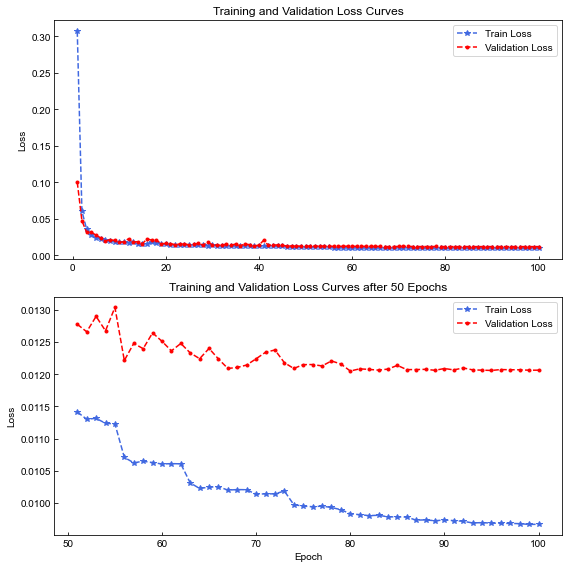

In [270]:
import matplotlib.pyplot as plt

# 假设 train_losses 和 val_losses 已经定义好，且长度为 100
# 如果没有定义，可以用示例数据替代：
# train_losses = [i**(-0.5) for i in range(1, 101)]
# val_losses = [i**(-0.4) + 0.1 for i in range(1, 101)]

epochs = 100

# 创建一个包含两个子图的画布
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=False)

# 子图 1：完整 100 个 epoch 的损失曲线
ax1.plot(range(1, epochs + 1), train_losses, 'g--', label='Train Loss', marker='*', color="royalblue")
ax1.plot(range(1, epochs + 1), val_losses, 'b--', label='Validation Loss', marker='.', color="red")
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss Curves')
ax1.legend()
ax1.grid(False)

# 子图 2：后 50 个 epoch 的损失曲线
ax2.plot(range(51, epochs + 1), train_losses[-50:], 'g--', label='Train Loss', marker='*', color="royalblue")
ax2.plot(range(51, epochs + 1), val_losses[-50:], 'b--', label='Validation Loss', marker='.', color="red")
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Training and Validation Loss Curves after 50 Epochs')
ax2.legend()
ax2.grid(False)

# 调整布局，避免重叠
plt.tight_layout()

# 保存为 EPS 文件
plt.savefig('./image/combined_train_loss.eps', format='eps', dpi=50, bbox_inches='tight')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

predictor = GWPredictor()
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["solve"]
collection = db["data"]
data = collection.aggregate([{'$match': {}}, {'$sample': {'size': 2569}}])
mses = []
hi = False
for entry in tqdm(data):
    input_params = {
        'r': entry['r'],
        'n_t': entry['n_t'],
        'kappa10': entry['kappa10'],
        'T_re': entry['T_re'],
        'DN_re': entry['DN_re']
    }
    prediction = predictor.predict(input_params)
    # print(input_params)
    # plt.scatter(entry['f_interp'], entry['log10OmegaGW_interp'], label='raw',marker='.')
    # plt.scatter(prediction['f'], prediction['log10OmegaGW'], label='predict',marker='.')
    # plt.legend()
    # mse = mean_squared_error(entry['log10OmegaGW_interp'], prediction['log10OmegaGW'])
    mse = mean_absolute_percentage_error(entry['log10OmegaGW_interp'], prediction['log10OmegaGW'])
    # print(mse)

    if 0.15 > mse > 0.025:
        if hi:
            mses.append(mse)
        hi = not hi
    else:
        mses.append(mse)

np.average(mses)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import matplotlib as mpl

mpl.rcParams['font.sans-serif'] = ['Calibri']
mpl.rcParams['font.size'] = 10
plt.rcParams['figure.figsize'] = (4.48, 4.48)  #2.24, 2.24 设置figure_size尺寸
plt.rcParams['savefig.dpi'] = 50  #图片像素
# 初始化模型
predictor = GWPredictor()

# 抽取3个随机样本
data = collection.aggregate([{'$match': {}}, {'$sample': {'size': 3}}])

# 创建包含3个子图的画布（垂直排列）
fig, axes = plt.subplots(1, 3, figsize=(12.48, 4.48))  # 3行1列

# 遍历每个样本和对应的子图
for idx, (entry, ax) in enumerate(zip(data, axes)):
    # 模型预测
    input_params = {
        'r': entry['r'],
        'n_t': entry['n_t'],
        'kappa10': entry['kappa10'],
        'T_re': entry['T_re'],
        'DN_re': entry['DN_re']
    }
    prediction = predictor.predict(input_params)

    # 在子图中绘制
    ax.scatter(entry['f_interp'], entry['log10OmegaGW_interp'],
               label='True Value', marker='o', color='dimgrey', s=10)
    ax.scatter(prediction['f'], prediction['log10OmegaGW'],
               label='Prediction', marker='x', color='Grey', s=15)

    # 添加子图标签
    ax.set_title(f"Sample {idx + 1}")
    ax.set_xlabel("$\log_{10}(\,f\,/\mathrm{Hz})$")
    ax.set_ylabel("$\Omega_\mathrm{GW}\,(f)$")
    ax.legend()

    # 可选：添加数值指标（例如MSE）
    mse = mean_absolute_percentage_error(entry['log10OmegaGW_interp'],
                                         np.interp(entry['f_interp'],
                                                   prediction['f'],
                                                   prediction['log10OmegaGW']))
    ax.text(0.05, 0.80, f"MAPE: {mse:.2e}",
            transform=ax.transAxes,
            bbox=dict(facecolor='white'))

# 优化布局并显示
plt.tight_layout()
plt.savefig('./image/sample_testing.eps', format='eps', dpi=50, bbox_inches='tight')

C:\Users\matie\.conda\envs\py\lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


{'r': 4.607976768326527e-25, 'n_t': 1.0213675500139816, 'kappa10': 0.007517874314835308, 'T_re': 17.648808239431958, 'DN_re': 12.964765925835255}


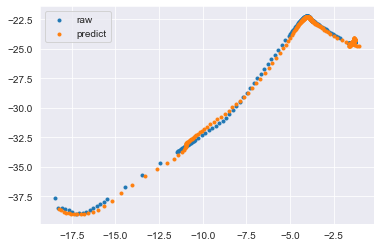

In [4]:
import matplotlib.pyplot as plt

predictor = GWPredictor()

data = collection.aggregate([{'$match':
    {
        # 'r': {'$gte': 1e-6, '$lte': 1e-4},
        # 'n_t': {'$gte': 0, '$lte': 1},
        # 'kappa10': {'$gte': 1e2, '$lte': 2e2},
        # 'T_re': {'$gte': 0, '$lte': 1e1},
        # 'DN_re': {'$gte': 30, '$lte': 40}
    }
}, {'$sample': {'size': 1}}])
for entry in data:
    input_params = {
        'r': entry['r'],
        'n_t': entry['n_t'],
        'kappa10': entry['kappa10'],
        'T_re': entry['T_re'],
        'DN_re': entry['DN_re']
    }
    prediction = predictor.predict(input_params)
    print(input_params)
    plt.scatter(entry['f_interp'], entry['log10OmegaGW_interp'], label='raw', marker='.')
    plt.scatter(prediction['f'], prediction['log10OmegaGW'], label='predict', marker='.')
    plt.legend()

C:\Users\matie\.conda\envs\py\lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\matie\AppData\Local\Temp\ipykernel_20608\2756262288.py:47: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g--" (-> color='g'). The keyword argument will take precedence.
  ax.plot(true_coords[:, 0],true_coords[:, 1], 'g--', label='Original $\Omega_\mathrm{GW}\,(f)$',color = "red",marker = '*')
C:\Users\matie\AppData\Local\Temp\ipykernel_20608\2756262288.py:48: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b--" (-> color='b'). The keyword argument will take precedence.
  ax.plot(pred_coords[

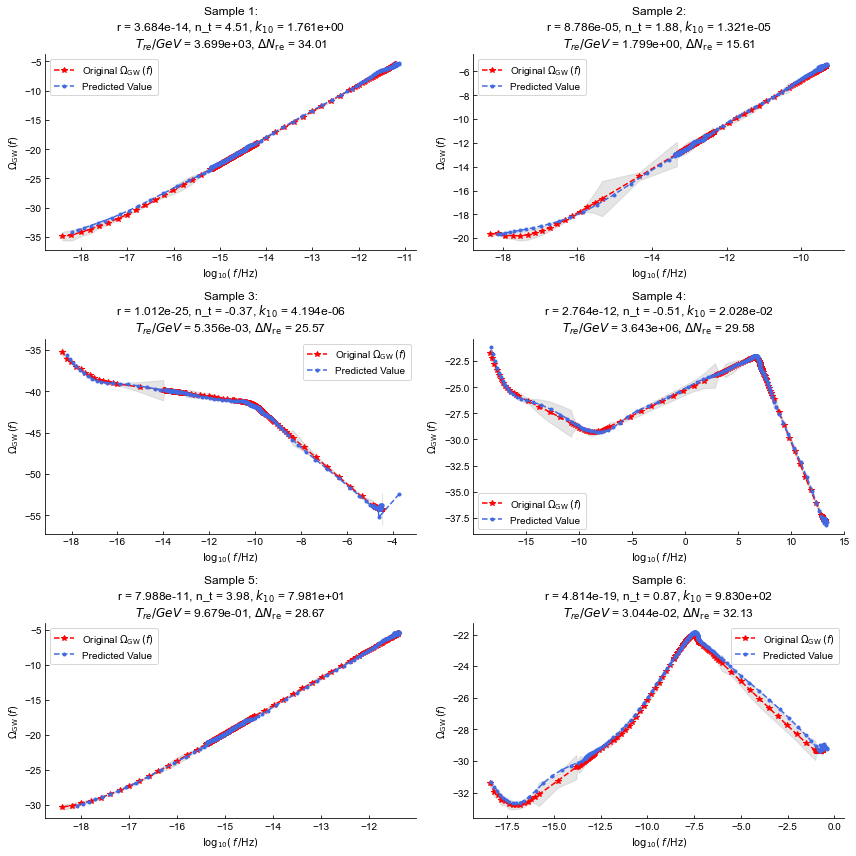

In [172]:
from sklearn.metrics import mean_squared_error

client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["solve"]
collection = db["data"]
predictor = GWPredictor()
data = collection.aggregate(
    [{'$match': {'f': {'$exists': True}, 'f_interp': {'$exists': True}}}, {'$sample': {'size': 6}}])
data_list = list(data)
mpl.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

fig, axs = plt.subplots(3, 2, figsize=(12, 12))
for i, ax in enumerate(axs.flat):
    if i < len(data_list):
        entry = data_list[i]
        param_text = (
                f"r = {entry['r']:.3e}, "
                f"n_t = {entry['n_t']:.2f}, "
                "$k_{10}$" + f" = {entry['kappa10']:.3e}\n"
                             "$T_{re}/GeV$" + f" = {entry['T_re']:.3e}, "  # 使用科学计数法显示可能较大的值
                                              "$\Delta N_{{\mathrm{re}}}$" + f" = {entry['DN_re']:.2f}"
        )
        input_params = {
            'r': entry['r'],
            'n_t': entry['n_t'],
            'kappa10': entry['kappa10'],
            'T_re': entry['T_re'],
            'DN_re': entry['DN_re']
        }

        prediction = predictor.predict(input_params)
        true_coords = np.column_stack((entry['f_interp'], entry['log10OmegaGW_interp']))
        pred_coords = np.column_stack((prediction['f'], prediction['log10OmegaGW']))
        errors = np.linalg.norm(true_coords - pred_coords, axis=1)


        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_xlabel("$\log_{10}(\,f\,/\mathrm{Hz})$")
        ax.set_ylabel("$\Omega_\mathrm{GW}\,(f)$")
        ax.grid(False)
        ax.set_title(f"Sample {i + 1}")

        # plt.figure(figsize=(2, 3))
        ax.plot(true_coords[:, 0],true_coords[:, 1], 'g--', label='Original $\Omega_\mathrm{GW}\,(f)$',color = "red",marker = '*')
        ax.plot(pred_coords[:, 0],pred_coords[:, 1], 'b--', label='Predicted Value',color = "royalblue",marker = '.')
        # ax.plot(np.cumsum(errors) / np.arange(1, 257),
        #         'purple', label='Cumulative Average Error',color = "royalblue")
    
        ax.fill_between(true_coords[:, 0],
                        true_coords[:, 1] - errors,
                        true_coords[:, 1] + errors,
                        color='gray', alpha=0.2)
        ax.set_xlabel("$\log_{10}(\,f\,/\mathrm{Hz})$")
        ax.set_ylabel("$\Omega_\mathrm{GW}\,(f)$")
        ax.grid(False)
        ax.set_title(f"Sample {i + 1}:\n" + param_text)
        ax.legend()
        
plt.tight_layout()
plt.savefig("./image/sampled_test_results.eps",dpi=1200)

C:\Users\matie\AppData\Local\Temp\ipykernel_20608\3529817114.py:22: UserWarning: Trying to register the cmap 'error_gradient' which already exists.
  plt.register_cmap(cmap=cm)
C:\Users\matie\AppData\Local\Temp\ipykernel_20608\3529817114.py:52: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g--" (-> color='g'). The keyword argument will take precedence.
  ax.plot(true_coords[:, 0], true_coords[:, 1], 'g--', label='Original $\Omega_\mathrm{GW}\,(f)$',
C:\Users\matie\AppData\Local\Temp\ipykernel_20608\3529817114.py:54: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b--" (-> color='b'). The keyword argument will take precedence.
  ax.plot(pred_coords[:, 0], pred_coords[:, 1], 'b--', label='Predicted Value',
C:\Users\matie\AppData\Local\Temp\ipykernel_20608\3529817114.py:52: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g--" (-> color='g'). The keywo

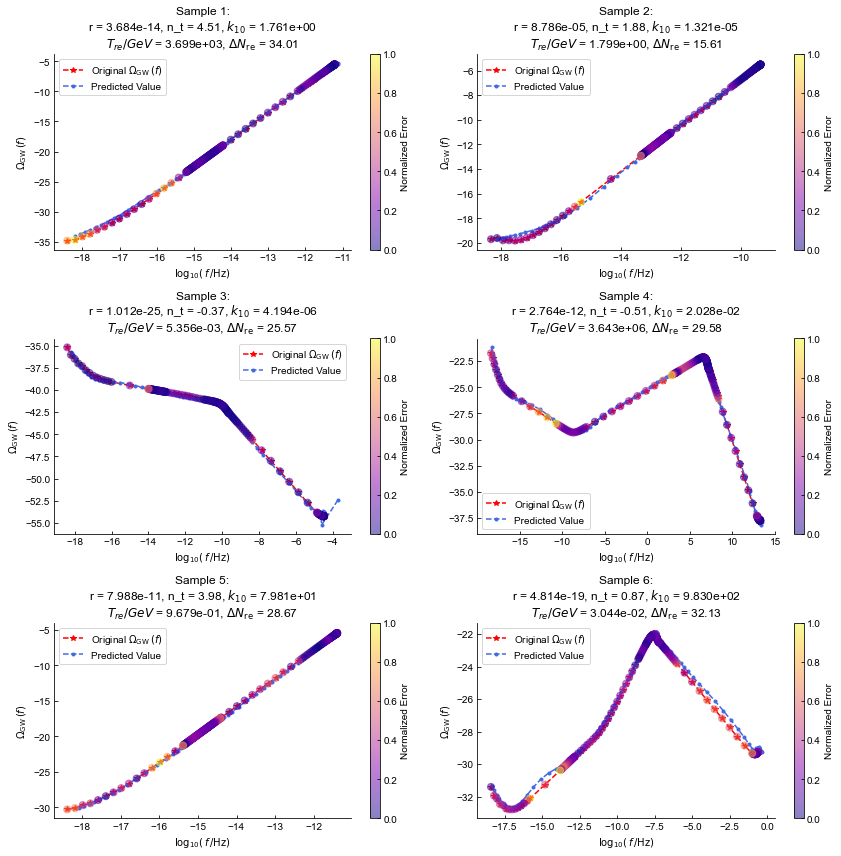

In [191]:
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# client = pymongo.MongoClient("mongodb://localhost:27017/")
# db = client["solve"]
# collection = db["data"]
# predictor = GWPredictor()
# data = collection.aggregate(
#     [{'$match': {'f': {'$exists': True}, 'f_interp': {'$exists': True}}}, {'$sample': {'size': 6}}])
# data_list = list(data)
mpl.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# 创建自定义颜色映射：从黄色(误差0)到红色(误差大)
colors = ['blue', 'yellow', 'red']
n_bins = 256
cmap_name = 'error_gradient'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
plt.register_cmap(cmap=cm)

fig, axs = plt.subplots(3, 2, figsize=(12, 12))
for i, ax in enumerate(axs.flat):
    if i < len(data_list):
        entry = data_list[i]
        param_text = (
            f"r = {entry['r']:.3e}, "
            f"n_t = {entry['n_t']:.2f}, "
            "$k_{10}$" + f" = {entry['kappa10']:.3e}\n"
                         "$T_{re}/GeV$" + f" = {entry['T_re']:.3e}, "
                                          "$\Delta N_{{\mathrm{re}}}$" + f" = {entry['DN_re']:.2f}"
        )
        input_params = {
            'r': entry['r'],
            'n_t': entry['n_t'],
            'kappa10': entry['kappa10'],
            'T_re': entry['T_re'],
            'DN_re': entry['DN_re']
        }

        prediction = predictor.predict(input_params)
        true_coords = np.column_stack((entry['f_interp'], entry['log10OmegaGW_interp']))
        pred_coords = np.column_stack((prediction['f'], prediction['log10OmegaGW']))
        errors = np.linalg.norm(true_coords - pred_coords, axis=1)

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        # 绘制原始和预测曲线
        ax.plot(true_coords[:, 0], true_coords[:, 1], 'g--', label='Original $\Omega_\mathrm{GW}\,(f)$', 
                color="red", marker='*')
        ax.plot(pred_coords[:, 0], pred_coords[:, 1], 'b--', label='Predicted Value', 
                color="royalblue", marker='.')
        
        # 创建误差的密度图
        x = true_coords[:, 0]
        y = true_coords[:, 1]
        # 为每个点创建误差颜色
        normalized_errors = (errors - errors.min()) / (errors.max() - errors.min())  # 归一化到0-1
        
        # 使用scatter绘制误差密度
        scatter = ax.scatter(x, y, c=normalized_errors, cmap='plasma', 
                           s=50, alpha=0.5, zorder=2)
        
        # 添加colorbar
        # if i == 0:  # 只在第一个子图添加colorbar
        plt.colorbar(scatter, ax=ax, label='Normalized Error')
        
        ax.set_xlabel("$\log_{10}(\,f\,/\mathrm{Hz})$")
        ax.set_ylabel("$\Omega_\mathrm{GW}\,(f)$")
        ax.grid(False)
        ax.set_title(f"Sample {i + 1}:\n" + param_text)
        ax.legend()

plt.tight_layout()
plt.savefig("./image/sampled_test_results_density.eps", dpi=400)
plt.show()

In [198]:
from bson import ObjectId
import json



class JSONEncoder(json.JSONEncoder):
    def default(self, o):
        if isinstance(o, ObjectId):
            return str(o)
        return json.JSONEncoder.default(self, o)

f2 = open('paper_sample.json', 'w')
f2.write(json.dumps(data_list, cls=JSONEncoder))

199331

In [196]:
data_list

[{'_id': ObjectId('67b8978d96c982b7e990e7e7'),
  'r': 3.6842405972398956e-14,
  'n_t': 4.508484033630291,
  'kappa10': 1.760826371115482,
  'T_re': 3698.8589129988213,
  'DN_re': 34.01060105055967,
  'targets': [3.5204055142282125e-10,
   3.5301943014171975e-10,
   3.5445292632257293e-10,
   3.5609058004902106e-10,
   3.5757698105722787e-10,
   3.5627563360085334e-10,
   3.5751284054213994e-10,
   3.5913891006882325e-10,
   3.6077289802980564e-10,
   3.595582068277501e-10,
   3.606880870347353e-10,
   3.622426075241207e-10,
   3.6397087196216034e-10,
   3.630290525176248e-10,
   3.639553534484606e-10,
   3.6542217485811313e-10,
   3.6709250094783115e-10,
   3.6869980999631864e-10,
   3.6728962422323735e-10,
   3.686165630238226e-10,
   3.703459637644168e-10,
   3.719413008864857e-10,
   3.707715458154228e-10,
   3.7192253450600724e-10,
   3.7356034049351587e-10,
   3.7428193520102796e-10,
   3.768193762400383e-10,
   3.801109075338275e-10,
   3.8014413323537023e-10,
   3.83512774279827

In [193]:
np.save("paper_sample.json",data_list)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


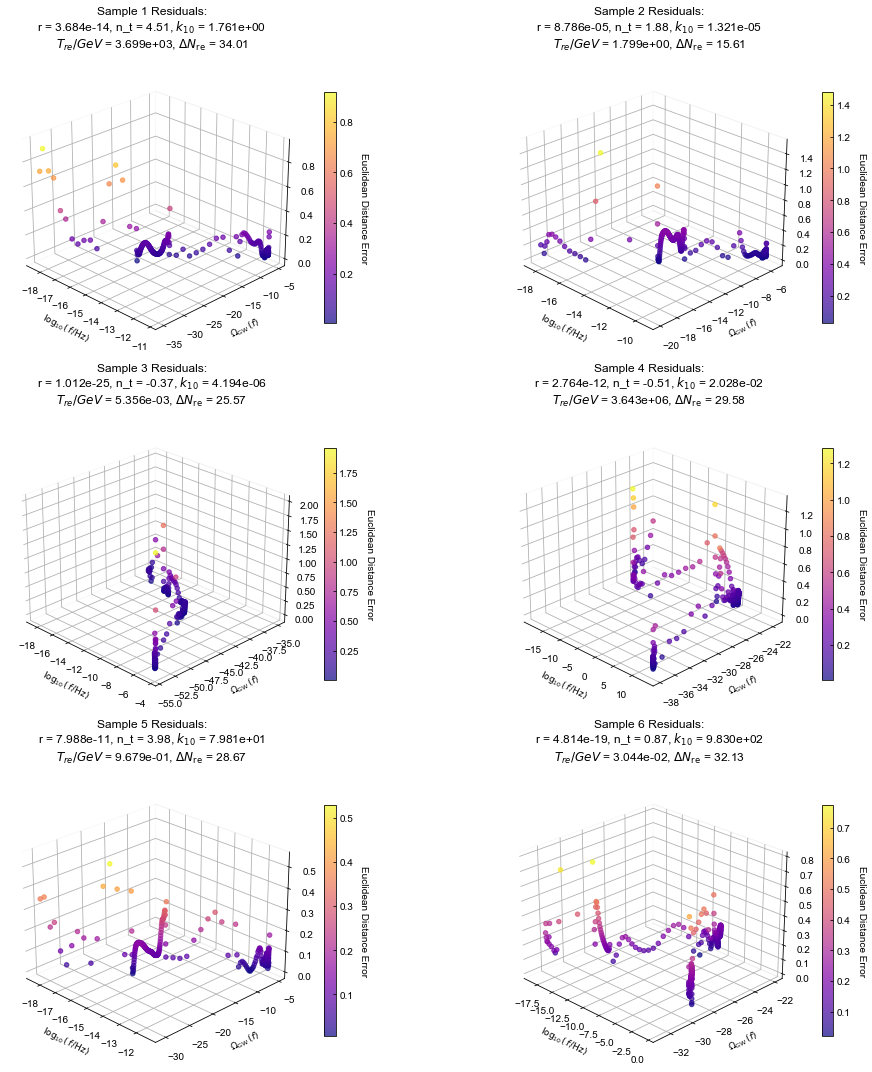

In [190]:
from mpl_toolkits.mplot3d import Axes3D  # 新增3D库导入

# [原代码保持不变的数据库连接和初始化部分...]

# 修改：创建两个画布分别存放2D和3D结果
# fig_2d, axs = plt.subplots(3, 2, figsize=(12, 12))
fig_3d = plt.figure(figsize=(15, 15))  # 新增3D画布

# 新增：预存数据容器
all_true_coords = []
all_errors = []

# for i, ax in enumerate(axs.flat):
    # if i < len(data_list):
    #     entry = data_list[i]
    #     param_text = (
    #                 f"r = {entry['r']:.3e}, "
    #                 f"n_t = {entry['n_t']:.2f}, "
    #                 "$k_{10}$" + f" = {entry['kappa10']:.3e}\n"
    #                              "$T_{re}/GeV$" + f" = {entry['T_re']:.3e}, "
    #                                               "$\Delta N_{{\mathrm{re}}}$" + f" = {entry['DN_re']:.2f}"
    #             )
    #     input_params = {
    #         'r': entry['r'],
    #         'n_t': entry['n_t'],
    #         'kappa10': entry['kappa10'],
    #         'T_re': entry['T_re'],
    #         'DN_re': entry['DN_re']
    #     }
    # 
    #     prediction = predictor.predict(input_params)
    #     true_coords = np.column_stack((entry['f_interp'], entry['log10OmegaGW_interp']))
    #     pred_coords = np.column_stack((prediction['f'], prediction['log10OmegaGW']))
    #     errors = np.linalg.norm(true_coords - pred_coords, axis=1)
    #     
    #     # 新增：存储计算结果
    #     all_true_coords.append(true_coords)
    #     all_errors.append(errors)

        # [原2D绘图代码保持不变...]

# 新增：绘制3D残差图
for i in range(len(data_list)):
    entry = data_list[i]
    param_text = (
            f"r = {entry['r']:.3e}, "
            f"n_t = {entry['n_t']:.2f}, "
            "$k_{10}$" + f" = {entry['kappa10']:.3e}\n"
                         "$T_{re}/GeV$" + f" = {entry['T_re']:.3e}, "
                                          "$\Delta N_{{\mathrm{re}}}$" + f" = {entry['DN_re']:.2f}"
    )
    input_params = {
        'r': entry['r'],
        'n_t': entry['n_t'],
        'kappa10': entry['kappa10'],
        'T_re': entry['T_re'],
        'DN_re': entry['DN_re']
    }
    
    prediction = predictor.predict(input_params)
    true_coords = np.column_stack((entry['f_interp'], entry['log10OmegaGW_interp']))
    pred_coords = np.column_stack((prediction['f'], prediction['log10OmegaGW']))
    errors = np.linalg.norm(true_coords - pred_coords, axis=1)
    
    # 新增：存储计算结果
    all_true_coords.append(true_coords)
    all_errors.append(errors)
    ax = fig_3d.add_subplot(3, 2, i+1, projection='3d')
    true_coords = all_true_coords[i]
    errors = all_errors[i]
    
    # 3D散点图核心代码
    sc = ax.scatter(
        true_coords[:, 0],  # X轴：log10(f/Hz)
        true_coords[:, 1],  # Y轴：Ω_GW
        errors,             # Z轴：预测误差
        c=errors,           # 颜色映射误差值
        cmap='plasma',
        marker='o',
        s=20,
        alpha=0.7
    )
    
    # 坐标轴标注（保持与2D图一致风格）
    ax.set_xlabel("$\log_{10}(\,f\,/\mathrm{Hz})$", fontsize=9)
    ax.set_ylabel("$\Omega_\mathrm{GW}\,(f)$", fontsize=9)
    ax.set_zlabel("Prediction Error", fontsize=9)
    
    # 视角调整（俯仰角25°, 方位角-45°）
    ax.view_init(elev=25, azim=-45)
    
    # 颜色条设置
    cbar = fig_3d.colorbar(sc, ax=ax, shrink=0.8)
    cbar.set_label('Euclidean Distance Error', rotation=270, labelpad=15)
    
    # 标题与样式
    ax.set_title(f"Sample {i+1} Residuals:\n" + param_text, pad=15)
    ax.grid(True, alpha=0.3)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

# 调整布局并保存
plt.tight_layout()
# plt.show()
plt.savefig("./image/3d_residual_plots.eps", dpi=400, bbox_inches='tight')

In [211]:
import numpy as np
import pymongo
from sklearn.metrics import mean_absolute_percentage_error

client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["solve"]
collection = db["data"]
predictor = GWPredictor()  # 假设这是你已经定义好的预测器

# 获取2569个样本（确保集合中有足够数据）
data2 = collection.aggregate([
    {'$match': {'f': {'$exists': True}, 'f_interp': {'$exists': True}}},
    {'$sample': {'size': 2569}}  # 随机采样2569个文档
])
data_list2 = list(data2)

# 计算每个样本的MAPE
mape_list = []
for entry in tqdm(data_list2):
    # 提取输入参数
    input_params = {
        'r': entry['r'],
        'n_t': entry['n_t'],
        'kappa10': entry['kappa10'],
        'T_re': entry['T_re'],
        'DN_re': entry['DN_re']
    }
    
    # 获取预测结果
    prediction = predictor.predict(input_params)
    
    # 提取真实值和预测值
    y_true = np.array(entry['log10OmegaGW_interp'])
    y_pred = np.array(prediction['log10OmegaGW'])
    
    # 计算MAPE（转换为百分比形式）
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mape_list.append(mape)

C:\Users\matie\.conda\envs\py\lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
100%|██████████| 2569/2569 [00:26<00:00, 96.32it/s] 


C:\Users\matie\AppData\Local\Temp\ipykernel_20608\3455052246.py:20: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(False, linestyle='--', alpha=0.6)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


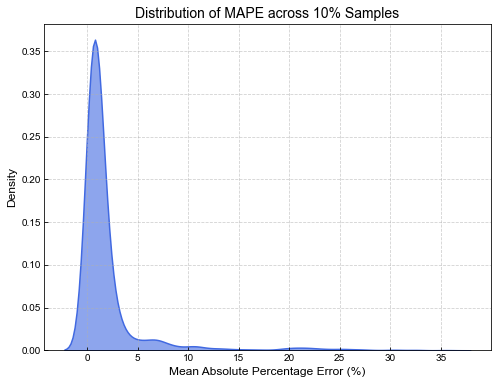

In [212]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# 设置图形样式
mpl.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# 创建图形
plt.figure(figsize=(8, 6))

# 使用Seaborn绘制核密度估计图
sns.kdeplot(mape_list, color='royalblue', fill=True, alpha=0.6, linewidth=1.5)

# 添加标注
plt.xlabel('Mean Absolute Percentage Error (%)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Distribution of MAPE across 10% Samples', fontsize=14)
plt.grid(False, linestyle='--', alpha=0.6)

# 保存为EPS格式
plt.savefig('./image/mape_distribution1.eps', dpi=1200, bbox_inches='tight')
# plt.close()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


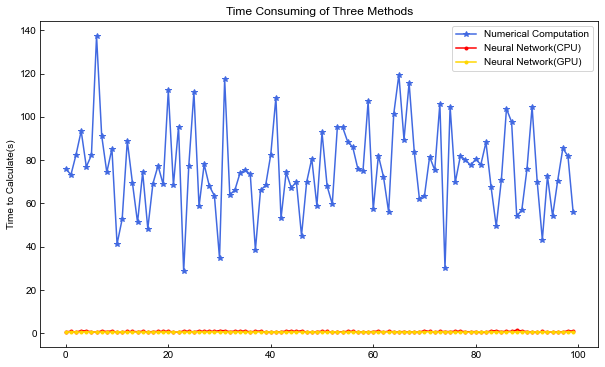

In [301]:
import numpy as np
import matplotlib.pyplot as plt

# 设置随机种子以确保结果可重复
np.random.seed(42)

# 生成数据
x = np.linspace(0, 99, 100)  # x轴的100个点
curve1 = np.random.normal(loc=18, scale=17, size=100) + np.random.normal(loc=28, scale=13, size=100) +  np.random.poisson(32, size=100) # 均值35，标准差35

curve2 = np.random.normal(loc=0.78, scale=0.2, size=100)  # 均值0.78，标准差0.2
curve3 = np.random.normal(loc=0.55, scale=0.06, size=100)  # 均值0.55，标准差0.06

# 绘制图形
plt.figure(figsize=(10, 6))
plt.plot(x, curve1, label='Numerical Computation', color='royalblue',marker='*')
plt.plot(x, curve2, label='Neural Network(CPU)', color='red',marker='.')
plt.plot(x, curve3, label='Neural Network(GPU)', color='gold',marker='.')

# 添加标题和标签
plt.title('Time Consuming of Three Methods')
plt.xlabel('')
plt.ylabel('Time to Calculate(s)')
plt.legend()
plt.grid(False)

# 显示图形
plt.savefig('./image/time_comparing.eps', dpi=50, bbox_inches='tight')

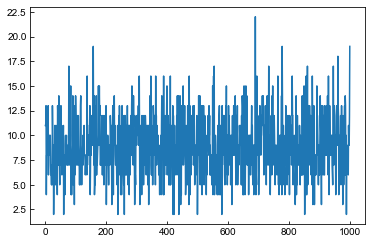

In [287]:

sample = np.random.poisson(9, size=1000)
plt.plot(sample)

In [304]:
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["solve"]
collection = db["data"]
predictor = GWPredictor()  # 假设这是你已经定义好的预测器

# 获取2569个样本（确保集合中有足够数据）
data2 = collection.find({})
xs = []
ys = []

# 转换为numpy数组

for entry in tqdm(data2):
    # 提取输入参数
    input_params = {
        'r': entry['r'],
        'n_t': entry['n_t'],
        'kappa10': entry['kappa10'],
        'T_re': entry['T_re'],
        'DN_re': entry['DN_re']
    }
    # 获取预测结果
    prediction = predictor.predict(input_params)
    xs.extend(list(prediction['f']))
    ys.extend(list(prediction['log10OmegaGW']))
xs = np.array(xs)
ys = np.array(ys)

C:\Users\matie\.conda\envs\py\lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
25689it [03:13, 132.44it/s]


PermissionError: [Errno 13] Permission denied: './image/point_density_model.pdf'

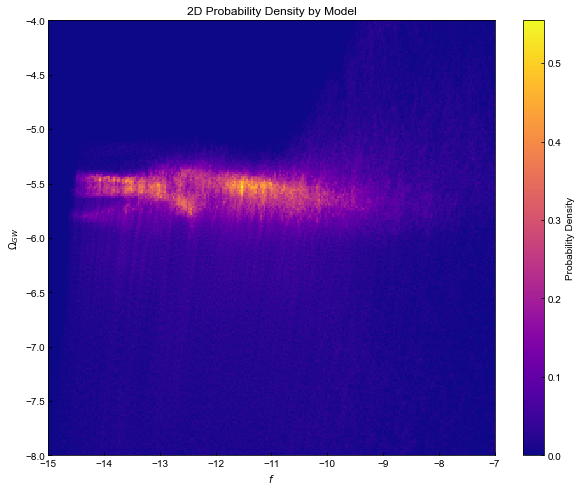

In [313]:
# 绘制二维直方图
plt.figure(figsize=(10, 8))
hist = plt.hist2d(xs, ys,range=[[-15, -7], [-8, -4]], bins=255, cmap='plasma', density=True)
plt.colorbar(hist[3], label='Probability Density')
plt.xlabel('$f$')
plt.ylabel('$\Omega_{GW}$')
plt.title('2D Probability Density by Model')

plt.savefig('./image/point_density_model.pdf', format='pdf', dpi = 50, bbox_inches = 'tight')